<a href="https://colab.research.google.com/github/roscibely/Animations-with-Matplotlib/blob/main/Dynamics_n_Pendulum_with_cart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

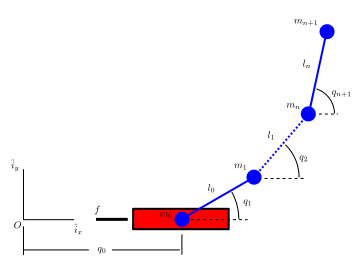

In [2]:
from IPython.display import SVG
SVG(filename='n-pendulum-with-cart.svg')

# Equations of Motion

In [4]:
from sympy import symbols
from sympy.physics.mechanics import *

n=5
q = dynamicsymbols('q:' + str(n + 1))  # Generalized coordinates
u = dynamicsymbols('u:' + str(n + 1))  # Generalized speeds
f = dynamicsymbols('f')                # Force applied to the cart

m = symbols('m:' + str(n + 1))         # Mass of each bob
l = symbols('l:' + str(n))             # Length of each link
g, t = symbols('g t')                  # Gravity and time

I = ReferenceFrame('I')                # Inertial reference frame
O = Point('O')                         # Origin point
O.set_vel(I, 0)                        # Origin's velocity is zero

P0 = Point('P0')                       # Hinge point of top link
P0.set_pos(O, q[0] * I.x)              # Set the position of P0    
P0.set_vel(I, u[0] * I.x)              # Set the velocity of P0
Pa0 = Particle('Pa0', P0, m[0])        # Define a particle at P0

In [6]:
frames = [I]                              # List to hold the n + 1 frames
points = [P0]                             # List to hold the n + 1 points
particles = [Pa0]                         # List to hold the n + 1 particles
forces = [(P0, f * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f
kindiffs = [q[0].diff(t) - u[0]]          # List to hold kinematic ODE's

for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i + 1], I.z])   # Create a new frame
    Bi.set_ang_vel(I, u[i + 1] * I.z)                         # Set angular velocity
    frames.append(Bi)                                         # Add it to the frames list

    Pi = points[-1].locatenew('P' + str(i + 1), l[i] * Bi.x)  # Create a new point
    Pi.v2pt_theory(points[-1], I, Bi)                         # Set the velocity
    points.append(Pi)                                         # Add it to the points list

    Pai = Particle('Pa' + str(i + 1), Pi, m[i + 1])           # Create a new particle
    particles.append(Pai)                                     # Add it to the particles list

    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point

    kindiffs.append(q[i + 1].diff(t) - u[i + 1])              # Define the kinematic ODE:  dq_i / dt - u_i = 0

kane = KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs) # Initialize the object
fr, frstar = kane.kanes_equations(forces, particles)     # Generate EoM's fr + frstar = 0

/usr/local/lib/python3.6/dist-packages/sympy/physics/mechanics/kane.py:533: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


# Simulation

In [12]:
from sympy import Dummy, lambdify
from numpy import array, hstack, zeros, linspace, pi,ones
from numpy.linalg import solve
from scipy.integrate import odeint

arm_length = 1. / n                          # The maximum length of the pendulum is 1 meter
bob_mass = 0.01 / n                          # The maximum mass of the bobs is 10 grams
parameters = [g, m[0]]                       # Parameter definitions starting with gravity and the first bob
parameter_vals = [9.81, 0.01 / n]            # Numerical values for the first two
for i in range(n):                           # Then each mass and length
    parameters += [l[i], m[i + 1]]
    parameter_vals += [arm_length, bob_mass]

dynamic = q + u                                                # Make a list of the states
dynamic.append(f)                                              # Add the input force
dummy_symbols = [Dummy() for i in dynamic]                     # Create a dummy symbol for each variable
dummy_dict = dict(zip(dynamic, dummy_symbols))
kindiff_dict = kane.kindiffdict()                              # Get the solved kinematical differential equations
M = kane.mass_matrix_full.subs(kindiff_dict).subs(dummy_dict)  # Substitute into the mass matrix 
F = kane.forcing_full.subs(kindiff_dict).subs(dummy_dict)      # Substitute into the forcing vector
M_func = lambdify(dummy_symbols + parameters, M)               # Create a callable function to evaluate the mass matrix 
F_func = lambdify(dummy_symbols + parameters, F)               # Create a callable function to evaluate the forcing vector 

In [8]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    u = 0.0                              # The input force is always zero     
    arguments = hstack((x, u, args))     # States, input, and parameters
    dx = array(solve(M_func(*arguments), # Solving for the derivatives
        F_func(*arguments))).T[0]

    return dx

In [13]:
x0 = hstack(( 0, pi / 2 * ones(len(q) - 1), 1e-3 * ones(len(u)) )) # Initial conditions, q and u
t = linspace(0, 10, 1000)                                          # Time vector
y = odeint(right_hand_side, x0, t, args=(parameter_vals,))         # Actual integration

# Plotting

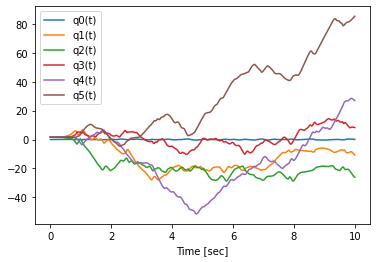

In [30]:
import matplotlib.pyplot as plt

lines = plt.plot(t, y[:,0:6])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(dynamic)

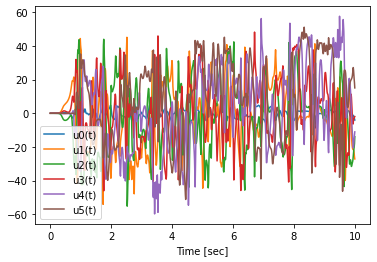

In [34]:
lines = plt.plot(t, y[:,6:12])
lab = plt.xlabel('Time [sec]')
leg = plt.legend(dynamic[6:12])

# Animation

In [35]:
from numpy import zeros, cos, sin, arange, around
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle


def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = states.shape[1] / 2

    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()

    # some dimesions
    cart_width = 0.4
    cart_height = 0.2

    # set the limits based on the motion
    xmin = around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = around(states[:, 0].max() + cart_width / 2.0, 1)

    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')

    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)

    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
        cart_width, cart_height, fill=True, color='red', ec='black')
    ax.add_patch(rect)

    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = hstack((states[i, 0], zeros((numpoints - 1))))
        y = zeros((numpoints))
        for j in arange(1, numpoints):
            x[j] = x[j - 1] + length * cos(states[i, j])
            y[j] = y[j - 1] + length * sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)

    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')

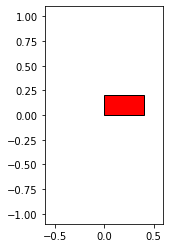

In [46]:
a=animate_pendulum(t, y, arm_length,filename="open-loop.mp4")

# Controller Design

In [ ]:
equilibrium_point = hstack(( 0, pi / 2 * ones(len(q) - 1), zeros(len(u)) ))
equilibrium_dict = dict(zip(q + u, equilibrium_point))
parameter_dict = dict(zip(parameters, parameter_vals))

# symbolically linearize about arbitrary equilibrium
linear_state_matrix, linear_input_matrix, inputs = kane.linearize()
# sub in the equilibrium point and the parameters
f_A_lin = linear_state_matrix.subs(parameter_dict).subs(equilibrium_dict)
f_B_lin = linear_input_matrix.subs(parameter_dict).subs(equilibrium_dict)
m_mat = kane.mass_matrix_full.subs(parameter_dict).subs(equilibrium_dict)
# compute A and B
from numpy import matrix
A = matrix(m_mat.inv() * f_A_lin)
B = matrix(m_mat.inv() * f_B_lin)

In [ ]:
import control
from numpy import dot, rank
from numpy.linalg import matrix_rank

assert matrix_rank(control.ctrb(A, B)) == A.shape[0]

K, X, E = control.lqr(A, B, ones(A.shape), 1);


In [ ]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    u = dot(K, equilibrium_point - x)    # The controller     
    arguments = hstack((x, u, args))     # States, input, and parameters
    dx = array(solve(M_func(*arguments), # Solving for the derivatives
        F_func(*arguments))).T[0]

    return dx

In [ ]:
x0 = hstack(( 0, pi / 2 * ones(len(q) - 1), 1 * ones(len(u)) )) # Initial conditions, q and u
t = linspace(0, 10, 1000)                                       # Time vector
y = odeint(right_hand_side, x0, t, args=(parameter_vals,))      # Actual integration

In [ ]:
animate_pendulum(t, y, arm_length, filename="closed-loop.mp4")

*source: https://www.moorepants.info/blog/npendulum.html*